1\. **Kernel Density Estimate**

Produce a KDE for a given distribution (by hand, not using seaborn!):

* Fill a numpy array, x,  of len(N) (with N=O(100)) with a variable normally distributed, with a given mean a standard deviation
* Fill an histogram in pyplot taking properly care about the aesthetic
   * use a meaningful number of bins
   * set a proper y axis label
   * set proper value of y axis major ticks labels (e.g. you want to display only integer labels)
   * display the histograms as data points with errors (the error being the poisson uncertainty)
* for every element of x, create a gaussian with the mean corresponding the element value and std as a parameter that can be tuned. The std default value should be:
$$ 1.06 * x.std() * x.size ^{-\frac{1}{5.}} $$
you can use the scipy function `stats.norm()` for that.
* In a separate plot (to be placed beside the original histogram), plot all the gaussian functions so obtained
* Sum (with np.sum()) all the gaussian functions and normalize the result such that the integral matches the integral of the original histogram. For that you could use the `scipy.integrate.trapz()` method


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
%matplotlib inline
from scipy.stats import norm
import scipy as sp

In [20]:
mu = 1
sigma = 0.2
N = 500
#find a mathematical relationship between the two
bin_number = 12
x = np.random.normal(loc = mu, scale = sigma, size = N)

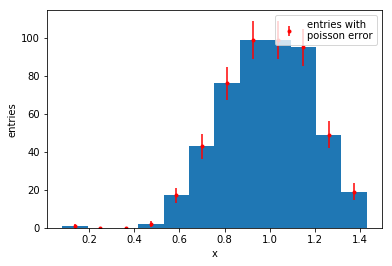

In [21]:
fig, ax = plt.subplots(figsize=(6, 4))
#ax.legend(loc='upper left')
ax.set_ylabel('entries')
ax.set_xlabel('x')
n, bins, _ = plt.hist(x, bins = bin_number)
#n, bins, _ = plt.hist(x, bins = bin_number, density = True)
medium_x = (bins[1:] + bins[:-1])/2
sigma_n = np.sqrt(n)
plt.errorbar(medium_x, n, sigma_n, fmt = 'r.', label = 'entries with \npoisson error')
plt.legend(loc = 'upper right')
plt.show()


In [22]:
#print(bins)
print(n)

[ 1.  0.  0.  2. 17. 43. 76. 99. 99. 95. 49. 19.]


In [23]:
A = (bins[-1]-bins[0])/bin_number*n.sum()
print(A)

56.25272315163523


In [24]:
#help(plt.hist)

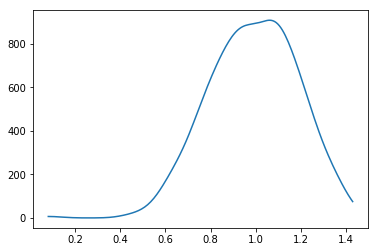

In [25]:
fig, ax = plt.subplots(figsize=(6, 4))
x_ax = np.linspace(x.min(), x.max(), num = 200)
gauss = np.zeros((N,200))
for i in range(N):
    gauss[i,:] = norm.pdf(x_ax, loc = x[i], scale = 1.06*x.std()*x.size**(-0.2))
    #ax.plot(x_ax, gauss[i,:], 'b')
#plt.show()
gauss_sum = np.sum(gauss, axis = 0)
plt.plot(x_ax, gauss_sum)


In [26]:
I = sp.integrate.trapz(gauss_sum, dx = (x.max()-x.min())/200)
print(I)

494.01683377914213


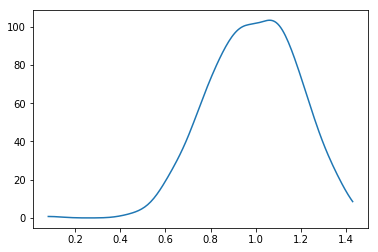

In [27]:
gauss_sum_norm = gauss_sum*A/I
plt.plot(x_ax, gauss_sum_norm)

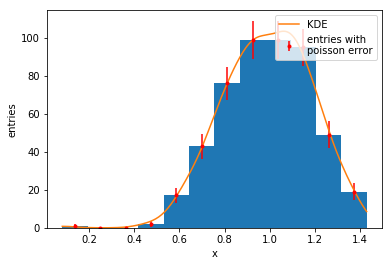

In [28]:
fig, ax = plt.subplots(figsize=(6, 4))
#ax.legend(loc='upper left')
ax.set_ylabel('entries')
ax.set_xlabel('x')
n, bins, _ = plt.hist(x, bins = bin_number)
medium_x = (bins[1:] + bins[:-1])/2
sigma_n = np.sqrt(n)
plt.errorbar(medium_x, n, sigma_n, fmt = 'r.', label = 'entries with \npoisson error')
#plt.plot(x_ax, gauss_sum_norm*N/bin_number, label = 'KDE')
plt.plot(x_ax, gauss_sum_norm, label = 'KDE')
plt.legend(loc = 'upper right')
plt.show()

In [11]:
#help(sp.integrate.trapz)
#help(norm.pdf)
#help(plt.subplots)
#help(np.sqrt)
#help(plt.errorbar)
#help(np.random.normal)
#help(plt.hist)

2\. **Color-coded scatter plot**

Produce a scatter plot out of a dataset with two categories

* Write a function that generate a 2D datasets of 2 categories. Each category should distribute as a 2D gaussian with a given mean and std (clearly it is better to have different values means..)
* Display the dataset in a scatter plot marking the two categories with different marker colors.

An example is given below

You can try to make the procedure more general by allowing a given number $n\ge 2$ of categories

--2018-12-04 15:40:11--  https://www.dropbox.com/s/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
Resolving www.dropbox.com (www.dropbox.com)... 162.125.69.1, 2620:100:6025:1::a27d:4501
Connecting to www.dropbox.com (www.dropbox.com)|162.125.69.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/u4y3k4kk5tc7j46/two_categories_scatter_plot.png [following]
--2018-12-04 15:40:12--  https://www.dropbox.com/s/raw/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucde03b81ad8dca8f84399dca37a.dl.dropboxusercontent.com/cd/0/inline/AW2XqEv6ANwlCWv0TLLC8Y2TwDPxzZlfotJfxaDa_FtVDuI32nx3toqSY5xlIUXm25iiRga73N_gTc-8TUNqKBMtte7qtgN42Scv3uMCLrRjYacAiU5Zn6glhnYl5fgLEg40Zh6hL45auu7m_UejX5X2h_nZA565RAT19FiVci6GEdld-salRiHMBRl37vxJwvM/file [following]
--2018-12-04 15:40:12--  https://ucde03b81ad8dca8f84399dca37a.dl.dropboxusercontent.com/cd/

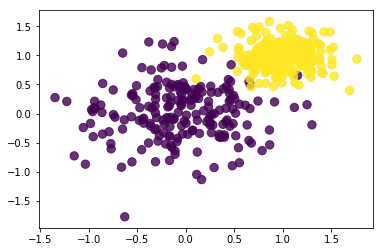

In [17]:
! wget https://www.dropbox.com/s/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
from IPython.display import Image
Image('two_categories_scatter_plot.png')


In [32]:
mu1 = [1,0]
sigma1 = [[0.6,0.2],[0.2,0.2]]
n1 = 1000
X1 = np.random.multivariate_normal(mu1, sigma1, n1)

mu2 = [0,1]
sigma2 = [[0.4,0.1],[0.1,0.2]]
n2 = 1000
X2 = np.random.multivariate_normal(mu2, sigma2, n2)

(1000, 3)


/opt/ubuntu-16.04/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


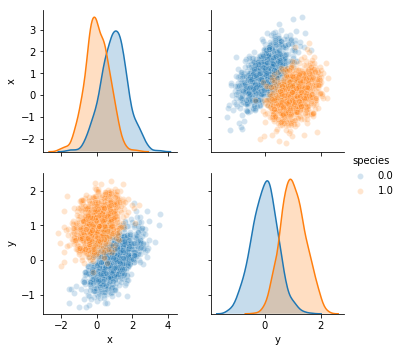

In [50]:
#help(np.concatenate)
import seaborn as sns

X1_label = np.concatenate((X1,np.zeros((n1,1))), axis = 1)
X2_label = np.concatenate((X2,np.zeros((n2,1))+1), axis = 1)

print(X1_label.shape)
X = pd.DataFrame(np.concatenate((X1_label,X2_label)), columns = ['x','y', 'species'])
#X = 

#sns.jointplot(x="x", y="y", data=X)

sns.pairplot(X, hue = 'species', vars = ['x','y'], plot_kws = {'alpha' : 0.2});

In [51]:
#help(sns.pairplot)

3\. **Profile plot**

Produce a profile plot from a scatter plot.
* Download the following dataset and load it as a pandas dataframe:
```bash
wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy
```
Note that you should you the `np.load()` function to load the file as a numpy array and then pass it to the `pd.DataFrame()` constructor.
* Inspect the dataset, you'll find two variables (features)
* Clean the sample by selecting the entries (rows) with the variable "residual" in absolute value smaller than 2
* perform a linear regression of "residuals" versus "distances" using `scipy.stats.linregress()` 
* plot a seaborn jointplot of  "residuals" versus "distances", having seaborn performing a linear regression. The result of the regression should be displayed on the plot
* Fill 3 numpy arrays
  * x, serving as an array of bin centers for the "distance" variable. It should range from 0 to 20 with reasonable number of steps (bins)
  * y, the mean values of the "residuals", estimated in slices (bins) of "distance"
  * erry, the standard deviation of the  of the "residuals", estimated in slices (bins) of "distance"
* Plot the profile plot on top of the scatter plot

In [52]:
! wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy

--2018-12-04 16:08:54--  https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy
Resolving www.dropbox.com (www.dropbox.com)... 162.125.69.1, 2620:100:6025:1::a27d:4501
Connecting to www.dropbox.com (www.dropbox.com)|162.125.69.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/hgnvyj9abatk8g6/residuals_261.npy [following]
--2018-12-04 16:08:54--  https://www.dropbox.com/s/raw/hgnvyj9abatk8g6/residuals_261.npy
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uce5f9850013b25d90ac15098e61.dl.dropboxusercontent.com/cd/0/inline/AW03wL_drvHEvQBT-rZfthqvzOntjEQTkzK2CIkQ3Dt5INT4_ZVcE9s5yrYm6IXGFIloFEEAjJjnc1Tw4w23s9Y37WAdVGHyfOHE-3vmXLE_aBzKwu6lBAiRgREBTLfT1eBFBaxmK-lTI5NQ9uRGH10ayEYiZGHApSlf3skBuq24fFlBpyyCcrc5c9Zad9n6QoU/file [following]
--2018-12-04 16:08:55--  https://uce5f9850013b25d90ac15098e61.dl.dropboxusercontent.com/cd/0/inline/AW03wL_drvHEvQBT-rZfthqvzOntjEQTk

In [79]:
#help(np.load)

In [80]:
v = np.load('residuals_261.npy')

In [81]:
v = v.reshape(1,1)

In [82]:
v = v[0][0]

In [83]:
df = pd.DataFrame.from_dict(v)

In [84]:
df.describe()

,residuals,distances
count,11131.000000,11131.000000
mean,-0.616477,9.771465
std,4.163705,5.877819
min,-160.850000,0.000000
25%,-0.330000,4.400000
50%,-0.110000,9.700000
75%,0.060000,14.900000
max,11.320000,24.900000


In [89]:
df = df[np.abs(df['residuals']) <2]

In [90]:
df.describe()

,residuals,distances
count,10489.000000,10489.000000
mean,-0.121878,9.954824
std,0.439143,5.847142
min,-2.000000,0.000000
25%,-0.280000,4.700000
50%,-0.100000,10.000000
75%,0.070000,15.100000
max,1.992857,24.900000
